In [4]:
from sympy import Matrix as Mx
from sympy import eye as I
from sympy import Symbol as S
from sympy import Eq
from sympy.physics.mechanics import dynamicsymbols as S_t
from sympy.physics.mechanics import init_vprinting
init_vprinting()
import sympy as sym

### State and input
$ u_j = [\omega_R, \omega_L]^T $ Wheel speeds.

$ x = [v, \omega]^T $ Base velocity.

$ \tau = [\tau_R, \tau_L]^T$ Motor torques (at the wheels).

In [18]:
omega_R = S_t('\omega_R')
omega_L = S_t('\omega_L')
h = Mx([omega_R, omega_L])

v     = S_t('v')
omega = S_t('\omega')
x = Mx([v, omega])

tau_R = S_t('\\tau_R')
tau_L = S_t('\\tau_L')
tau = Mx([tau_R, tau_L])

In [19]:
# Physical constants
d   = S('d')    # Distance between wheels
m   = S('m')    # Total Mass of the robot
I_z = S('I_z')  # Robot inertia about the wheels midpoint
I_W = S('I_W')  # Wheel + Gearbox rotational inertia (at the wheel)
r   = S('r')    # Wheel radius
l   = S('l')    # Forward CoM offset

Don't forget that
$I_z = I_{CoM} + l^2m$

### Diff-drive kinematics
Mapping from left and right wheel speeds to linear and angular velocity of the robot (no-slip assumption):

$x = J h$

In [27]:
J = Mx([[r/2,  r/2],
        [r/d, -r/d]])
J

⎡r   r ⎤
⎢─   ─ ⎥
⎢2   2 ⎥
⎢      ⎥
⎢r  -r ⎥
⎢─  ───⎥
⎣d   d ⎦

### Wheel dynamics
$ I_W \dot\omega_i = \tau_i - r f_i \space\space\space\space\space\space i \in {L, R}$ 

Solving for $f_i$ (the longitudinal contact forces) and stacking both wheels in matrix form: 

$ f = \frac{1}{r}\tau - \frac{I_W}{r} \dot h $

### Diff-drive dynamics
$ m \dot v = f_R + f_L$

$ I_z \dot \omega = \frac{d}{2} f_R - \frac{d}{2} f_L - l m \omega v$

The last, non-linear term, is the moment of the centrifugal force. We assume centrifugal acceleration does not have an x component, this is bad in case the turning radius is tighter than $l$. 

You can write those in matrix form as:

$ \dot x = a(x) + Bf $

In [26]:
a = Mx([0, - l * m * omega * v])
B = Mx([[1/m,      1/m    ],
        [d/2/I_z, -d/2/I_z]])
a, B

⎛                 ⎡  1      1  ⎤⎞
⎜                 ⎢  ─      ─  ⎥⎟
⎜⎡      0      ⎤  ⎢  m      m  ⎥⎟
⎜⎢             ⎥, ⎢            ⎥⎟
⎜⎣-l⋅m⋅\omega⋅v⎦  ⎢  d     -d  ⎥⎟
⎜                 ⎢─────  ─────⎥⎟
⎝                 ⎣2⋅I_z  2⋅I_z⎦⎠

The model would be linear if our robot had been built with $l=0$ as $b(x)$ would disappear. Intuitively, $b$ adds a quadratic yaw moment in turns (unless you turn in place).

The "quadraticness" is evident in a constant turn with radius $R$ or curvature $ R^{-1} = \kappa = \omega / v$:

$ 
lmv \omega = \frac{lm\omega^2}{R} = lm\kappa v^2 
$

### Full dynamics
Plug in the wheel dynamics and use $J$.

$ 
\dot x = a(x) + B f 
       = a(x) + \frac{1}{r} B \tau - \frac{I_W}{r} B \dot h 
       = a(x) + \frac{1}{r} B \tau - \frac{I_W}{r} B J^{-1} \dot x 
$

Solve for $\tau$ to get the inverse dynamics.

$ \tau = ( r B^{-1} + I_W J^{-1} ) (\dot x + b(x)) = M \dot x + b(x) $

$ M = r B^{-1} + I_W J^{-1} $ is the generalized inertia matrix and $b(x)=Ma(x)$ describes the non-linear inertial forces. Together they provide a coupled feed-forward law for linear and angular acceleration tracking.

Solve for $\dot x$ to obtain forward dynamics, useful for simulation or constraint propagation.

$ \dot x = M^{-1} ( \tau - b(x)) $

In [29]:
M = r * B.inv() + I_W * J.inv()
b = M * a
M, b

⎛⎡I_W   m⋅r   I_W⋅d   I_z⋅r ⎤  ⎡      ⎛I_W⋅d   I_z⋅r⎞          ⎤⎞
⎜⎢─── + ───   ───── + ───── ⎥  ⎢ -l⋅m⋅⎜───── + ─────⎟⋅\omega⋅v ⎥⎟
⎜⎢ r     2     2⋅r      d   ⎥  ⎢      ⎝ 2⋅r      d  ⎠          ⎥⎟
⎜⎢                          ⎥, ⎢                               ⎥⎟
⎜⎢I_W   m⋅r    I_W⋅d   I_z⋅r⎥  ⎢     ⎛  I_W⋅d   I_z⋅r⎞         ⎥⎟
⎜⎢─── + ───  - ───── - ─────⎥  ⎢-l⋅m⋅⎜- ───── - ─────⎟⋅\omega⋅v⎥⎟
⎝⎣ r     2      2⋅r      d  ⎦  ⎣     ⎝   2⋅r      d  ⎠         ⎦⎠

If the reference to track is given as wheel accelerations the feedforward law becomes 

$ \tau = M J \dot h + b(x) $

In [38]:
M_prime = r * B.inv() * J + I_W * I(2)  # M * J
Eq(u, M_prime * h.diff() + b)

           ⎡                                  ⎛       2      2⎞            ⎛  
           ⎢       ⎛I_W⋅d   I_z⋅r⎞            ⎜  I_z⋅r    m⋅r ⎟            ⎜  
           ⎢ - l⋅m⋅⎜───── + ─────⎟⋅\omega⋅v + ⎜- ────── + ────⎟⋅\omeġa_L + ⎜I
           ⎢       ⎝ 2⋅r      d  ⎠            ⎜     2      4  ⎟            ⎜  
⎡\tau_R⎤   ⎢                                  ⎝    d          ⎠            ⎝  
⎢      ⎥ = ⎢                                                                  
⎣\tau_L⎦   ⎢                                   ⎛       2      2⎞            ⎛ 
           ⎢      ⎛  I_W⋅d   I_z⋅r⎞            ⎜  I_z⋅r    m⋅r ⎟            ⎜ 
           ⎢- l⋅m⋅⎜- ───── - ─────⎟⋅\omega⋅v + ⎜- ────── + ────⎟⋅\omeġa_R + ⎜
           ⎢      ⎝   2⋅r      d  ⎠            ⎜     2      4  ⎟            ⎜ 
           ⎣                                   ⎝    d          ⎠            ⎝ 

         2      2⎞          ⎤
    I_z⋅r    m⋅r ⎟          ⎥
_W + ────── + ────⎟⋅\omeġa_R ⎥
       2      4  ⎟          ⎥
      d 

### Curvature Control
If the reference is given as
$ x_{des} = [v_{des}, \omega_{des}]^T $
but curvature tracking has priority then an intermediate reference $x_{\kappa}$ can be generated by a kinematic controller, which modifies the linear and angular velocity references to mitigate the effect of a disturbance on the curvature.

$\kappa_{des} = \frac{\omega_{des}}{v_{des}}$

$ \omega_\kappa = \kappa_{des} v = \frac{v}{v_{des}}\omega_{des} $ 

$ v_\kappa = \frac{\omega}{\kappa_{des}} = \frac{\omega}{\omega_{des}}v_{des} $

NOTE:
1. you need to address division by zero, possibly in a continuos manner.

2. if the robot is at standstill, this law prevents it from moving.

3. this only tracks curvature and no effort will be made to actually track $ x_{des} $. 

(2 is a special case of 3 where zero velocity leaves curvature undefined and you are virtually tracking *any* curvature).

You can design a tunable function $s$ to address these points.

$ 
x_{\kappa} = [v_{\kappa}, \omega_{\kappa}]^T =
[s(\omega, \omega_{des}) v_{des}, \space\space\space s(v, v_{des}) \omega_{des}]^T
$

The desired behaviour of $s(y, y_{des})$ is the following. When the desired value $y_{des}$ (denominator) is $0$, $s$ should be limited to $[0,1]$. When $y_{des}$ is not too close to zero, the function should continuously transition to simple division.

Given a tolerance $tol$ a piecewise linear implementation of the $y_{des}=0$ case could
- take the value 1 when $y < tol$ (effectively ignoring curvature); 
- take the value 0 when $y > 2tol$ (to stop if there is significant rotation or longitudinal movement when we intend to drive straight or turn in place respectively);
- linearly interpolate in between. 

Additionally, when computing the ratio, the denominator should be constrained to be at least greater than some small value for numerical stability.

Finally we can let some $ x_{des} $ always "leak" through to address points 2 and 3, taking some priority away from curvature tracking. If the leak is too small, some delay will still be present, if it is too large, the curvature tracking is compromised.

Here `s` is a simulation-tested implementation of $s$

```python
def bump(t):
    # This is just a trapezoidal impulse.
    return 2 - np.clip(abs(t), 1, 2)

def s(y, ydes, tol = 0.01):
    # For simplicity, fix ydes to be positive but preserve the sign of the ratio.
    y = math.copysign(y, ydes)  
    ydes = abs(ydes)
    # Pretend feedback is 10% closer to target (leak)
    y += (0.1 * (ydes - y))  
    ratio = y / max(tol, ydes)
    weight = min(ydes / tol, 1)
    return weight * ratio + (1 - weight) * bump(ratio)
```

##### Untested idea
The amount of "leak" could be determined by "how much we believe we can do before the next time step", in fact the "leak" does not even need to happen in `s()`.

You could predict the best you can do ($x_{pred}$) using constraints and forward dynamics (see $h_{clamp}$ below), this would not only solve points 2 and 3 above but also ensure that $ x_{pred}$  is feasible.
If you predict to reach the targets "exactly" the curvature adjustment is not needed. This curvature control would only intervene when $ x_{des} $ is not feasible, replacing it with a feasible reference $ x_{\kappa} $ with the closest possible curvature.

This is actually very simple if you draw the $ (v, \omega) $ plane. Box contraints on wheel torques correspond to box constraints on acceleration, which you can scale by the timestep to get a box of reachable states centered on your current state in the $ (v, \omega) $ plane. On this plane, equal curvature states are lines through the origin.

If $ x_{pred} $ activates both constraints (is on a corner) then it is already the best you can do, the required curvature is not feasible within the next time step. Blame the online trajectory generator!

If $ x_{pred} $ activates only one constraint (is on an edge) then you just need to intersect the active constraint with the line of constant curvature $\omega=\kappa_{des}v$. 

If in effect you do not reach it, then there is a model-mismatch, the low-level controller should take care of this. A feedback term here would only be a hack. I believe (religiously) that a reference should always be feasible and quantities should always have a physical meaning.

##### Another idea
You could use the closed-loop feedback terms from the LLC to measure the model mismatch and use it as part of the model in the calculation above or even $h_{clamp}$ below.

##### Another little idea
The trapezoidal impulse width could be adjustable, possibly degenerating into a triangle.

### Low Level Control
The target wheel accelerations can be computed as:

$ h_{des} = J^{-1} x_{\kappa} $

$ \dot h_{des} = clamp(k_{FF}(h_{des} - h))$

Where the scalar $k_{FF}$ can be made smaller for smoothing the reference (limiting the jerk $\ddot h$ ) when the error is small and $clamp$ restricts the reference to feasible and desireable values. 

If there are torque constraints $\tau_{max}$ (either derived from a friction model or actuator specifications) then $clamp$ should use them. You can convert torque limits to the acceleration limit of each wheel by using forward dynamics.

$ \dot h_{clamp} = J^{-1}(- b(x) + M^{-1} \tau_{max}) $

The Feedforward torque term is the following. If your model is good, this should be "doing most of the work".

$ u_{FF} = M (J \dot h_{des} + b(x))$

Feedback must be added to this for compensating disturbances.

$P$ on acceleration error, requires estimate of acceleration either by measurement or numerical differentiation, could be a reason to avoid it. I recommend this for high performance driving though.

$ P(\dot h) = k_P(\dot h_{des} - \dot h)$

To implement feedback at the velocity level without competing with the $FF$ term we must take care that the targets are coherent. So we use a fictitious velocity reference that is the integrated acceleration reference. 

$P$ on velocity error. The acceleration feedback integral is equivalent to the variation in velocity.

$ I(\dot h) = k_I\int{(\dot h_{des} - \dot h)dt}= k_I(\int{\dot h_{des}dt} - \Delta h)$

$I$ on velocity error. To avoid competition with the $FF$ term we integrate it and use it as the velocity reference.

$ I(h) = k_{I_2}\int{(\int{\dot h_{des}dt} - h)dt} $

$P$ or $D$ terms on the velocity error will compete with the . I speculate that once special care is taken to avoid that, they will effectively be identical to $I(\dot h)$ and $P(\dot h)$ repsectively.
 
Windup should be prevented by clamping the integrator values to the actuator limits minus the effort of the rest of the controller.

<!-- #### All together

$M$ and $J$ are constant matrices.

$ \omega_\kappa = \frac{v}{v_{des}}\omega_{des} \xrightarrow[v_{des} \to 0]{} \omega_{des}$ 

$ v_\kappa = \frac{\omega}{\omega_{des}}v_{des} \xrightarrow[\omega_{des} \to 0]{} v_{des}$

$h_{des} = J^{-1}x_{\kappa}$

$ \dot h_{des} = clamp(k_{FF}(h_{des} - h))$

$ u_{FF} = M (J \dot h_{des} + b(x)) $

$ P(\dot h) = k_P(\dot h_{des} - \dot h)$

$ I(\dot h) = k_I(\int{\dot h_{des}dt} - \Delta h)$

$ I(h) = k_{I_2}\int{(\int{\dot h_{des}hdt} - h)dt} $ -->

Finally 
$ u = u_{FF} + P(\dot h) +  P(h) + I(h) $

### Sanity checks
We expect a Linear term and a cross coupling term for each wheel.

The linear terms should not depend on the robot rotational inertia $I_z$.

The cross coupling terms should have equal magnitude and opposite signs for each wheel.

In [9]:
delta_W = S_t('\Delta_W')
Eq(delta_W, omega_R - omega_L)

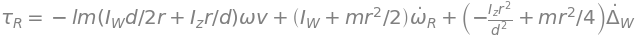

In [10]:
x_R = Mx([omega_R, delta_W])
T_R = Mx([[1,0],[1,1]])  # Re-parametrization matrix to [omega_R, delta_W]
Eq(tau_R, (M_prime * T_R * x_R.diff() + M * b)[0])

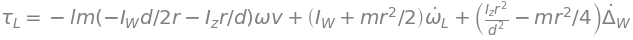

In [11]:
x_L = Mx([omega_L, delta_W])
T_L = Mx([[1,-1],[1,0]])  # Re-parametrization matrix to [omega_L, delta_W]
Eq(tau_L, (M_prime * T_L * x_L.diff() + M * b)[1])

Expectation confirmed!